<a href="https://colab.research.google.com/github/josematez/DeepLearning_SkinCancer/blob/main/DenseNet_BalancedData_GPU25GB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deepdish
!pip install numpy==1.15.4

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import deepdish as dd
#from tqdm import tqdm
#from glob import glob
#import seaborn as sns
#import pprint as pp

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils, to_categorical, plot_model
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator

#import itertools

#import cv2
#from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/ISIC_Dataset')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data = dd.io.load('ISIC_dataset.h5')
data_df = pd.DataFrame(data)

In [5]:
X_raw = data_df.image
Y = data_df.cell_type_idx

In [6]:
Y.value_counts()

4    6705
5    1113
2    1099
1     514
0     327
6     142
3     115
Name: cell_type_idx, dtype: int64

In [7]:
from imgaug import augmenters as iaa
from imgaug import parameters as iap

"""
Params de entrada: X, Y, num_muestras_clase
Params de salida: X_bal, Y_bal
"""
def balance_and_augmentation_data(X, Y, num_muestras_clase): 

  rows, cols, depth = X[0].shape
  num_clases = Y.nunique()
  num_muestras_init = Y.value_counts()

  X_bal = np.zeros((num_clases*num_muestras_clase, rows, cols, depth), dtype = np.uint8)
  Y_bal = np.zeros((num_clases*num_muestras_clase,), dtype = np.uint8)

  # Se define el operador para data augmentation
  seq = iaa.Sequential([
      iaa.GaussianBlur(
          sigma=iap.Uniform(0.0, 1.0)
      ),
      iaa.Affine(
          rotate=iap.Normal(0.0, 30),
          translate_px=iap.RandomSign(iap.Poisson(3))
      )
  ])

  next_idx = 0

  for cat in range(num_clases):

    n_imgs_generate = num_muestras_clase - num_muestras_init[cat]
    idx_imgs_cat = np.where(Y == cat)[0]

    for idx, img in enumerate(idx_imgs_cat):
      if idx < num_muestras_clase:
        X_bal[next_idx,:,:,:] = X[img]
        Y_bal[next_idx] = Y[img]
        next_idx += 1
      else:
        break

    if n_imgs_generate > 0:
      idx_new_imgs = np.random.randint(0, num_muestras_init[cat], n_imgs_generate)
      for idx in idx_new_imgs:
        X_bal[next_idx,:,:,:] = seq.augment_image(X[idx_imgs_cat[idx]])
        Y_bal[next_idx] = cat
        next_idx += 1

  return X_bal, Y_bal 

In [8]:
X_bal, Y_bal = balance_and_augmentation_data(X_raw, Y, 7000)

(49000, 75, 100, 3)


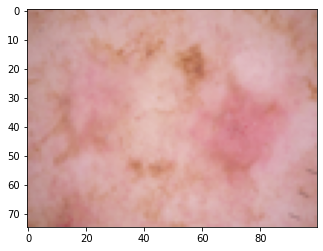

In [9]:
plt.imshow(X_bal[100], cmap = 'Greys')

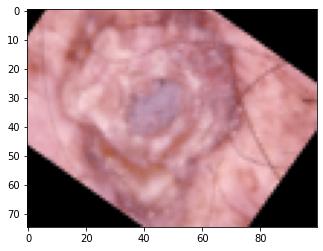

In [10]:
plt.imshow(X_bal[600], cmap = 'Greys')

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X_bal, Y_bal, test_size=0.2)

In [12]:
pd.Series(Y_train).value_counts()

5    5669
4    5641
2    5626
6    5584
1    5573
3    5572
0    5535
dtype: int64

In [13]:
print('X_bal shape: {}'.format(X_bal.shape))
print('Y_bal shape: {}'.format(Y_bal.shape))

X_bal shape: (49000, 75, 100, 3)
Y_bal shape: (49000,)


In [14]:
#X_train, X_test, Y_train, Y_test = train_test_split(X_bal, Y_bal, test_size=0.2)

In [15]:
X_train = (X_train / np.max(X_train))
X_test = (X_test / np.max(X_test))

In [16]:
n_classes = len(np.unique(Y_train))
Y_train = to_categorical(Y_train, num_classes = n_classes)
Y_test = to_categorical(Y_test, num_classes = n_classes)

In [17]:
print('X_train shape: {}'.format(X_train.shape))
print('Y_train shape: {}'.format(Y_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('Y_test shape: {}'.format(Y_test.shape))

X_train shape: (39200, 75, 100, 3)
Y_train shape: (39200, 7)
X_test shape: (9800, 75, 100, 3)
Y_test shape: (9800, 7)


In [18]:
# DENSENET201 MODEL
input_shape = X_train[0].shape

densenet = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
densenet.trainable = False

model = tf.keras.models.Sequential()
model.add(densenet)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.46))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.46))    
model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

In [19]:
epocas = 50
bs = 20
lr = 0.001
optim = Adam(learning_rate = lr)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
# Define checkpoint to save best Phase 1 weights
best_weights_ph1 = "ph1_weights_balanced.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph1, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
callbacks = [reduce_lr, checkpoint]

In [20]:
historico = model.fit(X_train, Y_train, epochs = epocas, batch_size = bs, validation_split = 0.1, callbacks = callbacks)

Epoch 1/50
1763/1764 [============================>.] - ETA: 0s - loss: 1.2243 - accuracy: 0.5580
Epoch 00001: val_loss improved from inf to 0.89488, saving model to ph1_weights_balanced.hdf5
1764/1764 [==============================] - 70s 39ms/step - loss: 1.2242 - accuracy: 0.5580 - val_loss: 0.8949 - val_accuracy: 0.6564
Epoch 2/50
1763/1764 [============================>.] - ETA: 0s - loss: 0.9770 - accuracy: 0.6341
Epoch 00002: val_loss improved from 0.89488 to 0.81657, saving model to ph1_weights_balanced.hdf5
1764/1764 [==============================] - 65s 37ms/step - loss: 0.9771 - accuracy: 0.6340 - val_loss: 0.8166 - val_accuracy: 0.6890
Epoch 3/50
1763/1764 [============================>.] - ETA: 0s - loss: 0.9219 - accuracy: 0.6542
Epoch 00003: val_loss improved from 0.81657 to 0.76844, saving model to ph1_weights_balanced.hdf5
1764/1764 [==============================] - 65s 37ms/step - loss: 0.9220 - accuracy: 0.6541 - val_loss: 0.7684 - val_accuracy: 0.7110
Epoch 4/50


In [21]:
model.load_weights(best_weights_ph1)

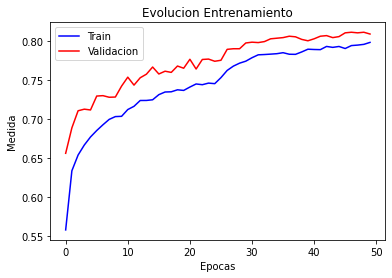

In [22]:
plt.plot(historico.history['accuracy'], c = 'b')
plt.plot(historico.history['val_accuracy'], c = 'r')
plt.legend(['Train', 'Validacion'])
plt.xlabel('Epocas')
plt.ylabel('Medida')
plt.title('Evolucion Entrenamiento')
plt.show()

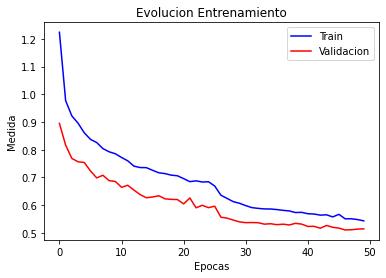

In [23]:
plt.plot(historico.history['loss'], c = 'b')
plt.plot(historico.history['val_loss'], c = 'r')
plt.legend(['Train', 'Validacion'])
plt.xlabel('Epocas')
plt.ylabel('Medida')
plt.title('Evolucion Entrenamiento')
plt.show()

In [24]:
metricas = model.evaluate(X_test, Y_test)

307/307 [==============================] - 11s 37ms/step - loss: 0.4904 - accuracy: 0.8186


In [25]:
densenet.trainable = True

epocas = 50
bs = 20
lr = 0.00001
optim = Adam(learning_rate = lr)
model.compile(optimizer = optim, loss = 'categorical_crossentropy', metrics = ['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
# Define checkpoint to save best Phase 1 weights
best_weights_ph2 = "ph2_weights_balanced.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph2, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
callbacks = [reduce_lr, checkpoint]

In [26]:
historico = model.fit(X_train, Y_train, epochs = epocas, batch_size = bs, validation_split = 0.1, callbacks = callbacks)

Epoch 1/50
1764/1764 [==============================] - ETA: 0s - loss: 1.3369 - accuracy: 0.5833
Epoch 00001: val_loss improved from inf to 0.72208, saving model to ph2_weights_balanced.hdf5
1764/1764 [==============================] - 145s 82ms/step - loss: 1.3369 - accuracy: 0.5833 - val_loss: 0.7221 - val_accuracy: 0.7378
Epoch 2/50
1764/1764 [==============================] - ETA: 0s - loss: 0.7922 - accuracy: 0.7158
Epoch 00002: val_loss improved from 0.72208 to 0.55154, saving model to ph2_weights_balanced.hdf5
1764/1764 [==============================] - 141s 80ms/step - loss: 0.7922 - accuracy: 0.7158 - val_loss: 0.5515 - val_accuracy: 0.7954
Epoch 3/50
1764/1764 [==============================] - ETA: 0s - loss: 0.6332 - accuracy: 0.7726
Epoch 00003: val_loss improved from 0.55154 to 0.49381, saving model to ph2_weights_balanced.hdf5
1764/1764 [==============================] - 141s 80ms/step - loss: 0.6332 - accuracy: 0.7726 - val_loss: 0.4938 - val_accuracy: 0.8337
Epoch 4/

In [27]:
model.load_weights(best_weights_ph2)

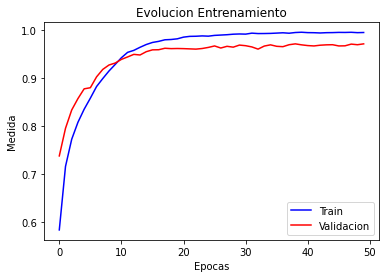

In [28]:
plt.plot(historico.history['accuracy'], c = 'b')
plt.plot(historico.history['val_accuracy'], c = 'r')
plt.legend(['Train', 'Validacion'])
plt.xlabel('Epocas')
plt.ylabel('Medida')
plt.title('Evolucion Entrenamiento')
plt.show()

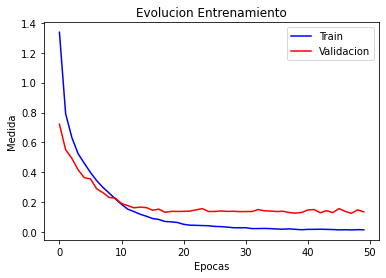

In [29]:
plt.plot(historico.history['loss'], c = 'b')
plt.plot(historico.history['val_loss'], c = 'r')
plt.legend(['Train', 'Validacion'])
plt.xlabel('Epocas')
plt.ylabel('Medida')
plt.title('Evolucion Entrenamiento')
plt.show()

In [30]:
metricas = model.evaluate(X_test, Y_test)

307/307 [==============================] - 11s 36ms/step - loss: 0.0933 - accuracy: 0.9774


In [31]:
Y_pred = model.predict(X_test)
print('Confusion Matrix')
print(confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)))

Confusion Matrix
[[1456    1    3    1    0    4    0]
 [   2 1414    2    0    9    0    0]
 [   1    3 1330    1   18   21    0]
 [   1    0    0 1427    0    0    0]
 [   1    5   38    2 1274   37    2]
 [   8    4   13    1   42 1263    0]
 [   0    0    1    0    0    0 1415]]


In [32]:
X = np.zeros((10015, 75, 100, 3), dtype = np.uint8)

for i in range(10015):
  X[i,:,:,:] = X_raw[i]

Y = data_df.cell_type_idx

In [33]:
X_train, X_test_2, Y_train, Y_test_2 = train_test_split(X, Y, test_size=0.2)

In [34]:
Y_test_2 = to_categorical(Y_test_2, num_classes = n_classes)
X_test_2 = (X_test_2 / np.max(X_test_2))

In [35]:
metricas = model.evaluate(X_test_2, Y_test_2)

63/63 [==============================] - 3s 43ms/step - loss: 0.0836 - accuracy: 0.9820


In [36]:
Y_pred_2 = model.predict(X_test_2)
print('Confusion Matrix')
print(confusion_matrix(Y_test_2.argmax(axis=1), Y_pred_2.argmax(axis=1)))

Confusion Matrix
[[  62    0    0    0    0    0    0]
 [   0  108    0    0    2    0    0]
 [   0    0  227    0    6    0    0]
 [   0    0    0   25    0    0    0]
 [   1    1    9    0 1289    3    0]
 [   1    0    1    0   12  223    0]
 [   0    0    0    0    0    0   33]]
